# Task 4. Choose one of the provided common datasets to work with. (Adult Dataset)

In [1]:
# Load all necessary packages
import sys
sys.path.insert(1, "../")  

import numpy as np
np.random.seed(0)

from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

from IPython.display import Markdown, display

In [2]:
X = AdultDataset()

In [3]:
import pandas as pd

In [4]:
X.feature_names[:5]

['age', 'education-num', 'race', 'sex', 'capital-gain']

In [5]:
X.protected_attribute_names

['race', 'sex']

Load dataset, specifying protected attribute, and split dataset into train and test

# 5. Select a protected attribute from your chosen dataset for the next steps.

We are using "Gender" as a protected Attribute.

In [6]:
dataset_orig = AdultDataset(
    protected_attribute_names = ['sex'],
    privileged_classes = [['Male']],
    #protected_attribute_names=["race", "sex"],           # this dataset also contains protected
                                                 # attribute for "sex" which we do not
                                                 # consider in this evaluation
    #privileged_classes=["White", "Male"],      # age >=25 is considered privileged
    features_to_drop=['native-country', 'race', 'education', 'relationship', 'marital-status']
    #features_to_keep=['race', 'capital-loss', 'education', 'education-num', 'workclass', 'age', 'fnlwgt', 'occupation',
                      #'capital-gain', 'hours-per-week'] # ignore sex-related attributes
)
print(dataset_orig.feature_names)


#privileged_groups = [{'race': 1, "sex": 1}]
#unprivileged_groups = [{"race": 0, "sex": 0}]
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

['age', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov', 'workclass=Private', 'workclass=Self-emp-inc', 'workclass=Self-emp-not-inc', 'workclass=State-gov', 'workclass=Without-pay', 'occupation=Adm-clerical', 'occupation=Armed-Forces', 'occupation=Craft-repair', 'occupation=Exec-managerial', 'occupation=Farming-fishing', 'occupation=Handlers-cleaners', 'occupation=Machine-op-inspct', 'occupation=Other-service', 'occupation=Priv-house-serv', 'occupation=Prof-specialty', 'occupation=Protective-serv', 'occupation=Sales', 'occupation=Tech-support', 'occupation=Transport-moving']


Compute fairness metric on original training dataset

# 6. Compute multiple fairness metrics on that attribute (minimum: 4).

In [7]:
results = {}
difference = {}

In [8]:
fairness_metrics = ["mean_difference", "average_odds_diffence", "balance_accuracy", "disparate_impact_ratio", "equalized_odds", "statistical_parity"]
bias_mitigation_algorithms = ["reweighing", "disparate_impact_remover", "adversarial debiasing",
                              "calibrated_eq_odds_postprocessing", "reject_option_classification"]

In [9]:
results = {"mean_difference": {"before_reweighing": None,
                               "after_reweighing": None},
           
           "disparate_impact_ratio": {"before_reweighing": None,
                                      "after_reweighing": None,
                                      "before_disparate_impact_remover": None,
                                      "after_disparate_impact_remover": None,
                                      "before_reject_option_classification": None,
                                      "after_reject_option_classification": None,
                                      "before_calibrated_eq_odds_postprocessing": None,
                                      "after_calibrated_eq_odds_postprocessing": None,
                                      "no_adversarial_debiasing": None,
                                      "adversarial_debiasing": None},
           
           "balanced_accuracy": {"before_calibrated_eq_odds_postprocessing": None,
                                "after_calibrated_eq_odds_postprocessing": None,
                                 
                                "before_reject_option_classification": None,
                                "after_reject_option_classification": None,
                                 
                                "no_adversarial_debiasing": None,
                                "adversarial_debiasing": None},
           
           "average_odds_difference": {"before_reject_option_classification": None,
                                       "after_reject_option_classification": None,
                                       
                                       "before_calibrated_eq_odds_postprocessing": None,
                                       "after_calibrated_eq_odds_postprocessing": None,
                                       
                                       "no_adversarial_debiasing": None,
                                      "adversarial_debiasing": None},
           
           "statistical_parity_difference": {"before_reject_option_classification": None,
                                             "after_reject_option_classification": None,
                                             
                                             "before_calibrated_eq_odds_postprocessing": None,
                                             "after_calibrated_eq_odds_postprocessing": None},
           
           "conditional_use_accuracy_equality": {"before_reject_option_classification": None,
                                  "after_reject_option_classification": None,
                                                "before_calibrated_eq_odds_postprocessing": None,
                                                 "after_calibrated_eq_odds_postprocessing": None}
          }

In [10]:
for key, value in results.items():
    for nes_key, nes_value in value.items():
        if nes_key == "before_reweighing" or nes_key == "after_reweighing":
            continue
        results[key][nes_key] = {"validation": None, "test": None}

In [11]:
results["mean_difference"]

{'before_reweighing': None, 'after_reweighing': None}

##### i. Mean difference <br> ii. Disparate Ratio without using CLassifier

In [12]:
results["mean_difference"]

{'before_reweighing': None, 'after_reweighing': None}

In [13]:
results["mean_difference"]["before_reweighing"]

In [14]:
metric_orig = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
#mean_diff["before_reweighing"] = metric_orig_train.mean_difference()
results["mean_difference"]["before_reweighing"] = metric_orig.mean_difference()
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.199110


##### ii. Disparate Impact Ratio

In [15]:
results["disparate_impact_ratio"]["before_reweighing"] = metric_orig.disparate_impact()
metric_orig.disparate_impact()

0.3631666646822667

### Step 4 Mitigate bias by transforming the original dataset

# 7. Try to mitigate bias using one of the bias mitigation algorithms provided by the toolkit

### Bias Mitigation Algorithm # 1: Reweighing

In [16]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf= RW.fit_transform(X)

##### What types of bias mitigation algorithm are available?

Three types of Bias Mitigation strategies:
<ul>
    <li>Pre-processing</li>
    <li>In-processing</li>
    <li>Post-processing</li>
</ul>
There are variety of Bias mitigation algorithms are available for each strategy, every algorithm is used to remove bias for specific metrics.In this exercise, we will apply these algorithms to mitigate Bias.

##### Do you see a difference between the different types of algorithms?

Yes, some of these algorithms during pre-processing step (i.e. Reweighing), while some mitigate bias during processing and some after processing. They have a different usage and solve specific problems corresponding to different measures.

# 8. Compute your fairness metrics again after the mitigation step.

##### i. Mean difference

In [17]:
metric_transf = BinaryLabelDatasetMetric(dataset_transf, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
results["mean_difference"]["after_reweighing"] = metric_transf.mean_difference()
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


##### ii. Disparate Impact after Reweighing

In [18]:
results["disparate_impact_ratio"]["after_reweighing"] = metric_transf.disparate_impact()
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf.disparate_impact())

Difference in mean outcomes between unprivileged and privileged groups = 1.000000


##### <br> ii. Disparate Impact Ratio (with Disparate Impact Remover)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

In [20]:
dataset_orig.favorable_label, dataset_orig.unfavorable_label

(1.0, 0.0)

In [21]:
metric_orig_new = BinaryLabelDatasetMetric(dataset_orig, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
results["disparate_impact_ratio"]["before_disparate_impact_remover"] = metric_orig_new.disparate_impact()
metric_orig_new.disparate_impact()

0.3631666646822667

### Bias Mitigation Algorithm # 2: Disparate Impact Remover

In [22]:
ad = AdultDataset(
protected_attribute_names = ['sex'],
privileged_classes = [['Male']], features_to_drop=['native-country', 'race', 'education', 'relationship', 'marital-status'])

In [23]:
from tqdm import tqdm

In [24]:
import matplotlib.pyplot as plt
DIs = []
def disparate_impact_remover(ad):
    scaler = MinMaxScaler(copy=False)
    
    test, train = ad.split([16281])
    train.features = scaler.fit_transform(train.features)
    test.features = scaler.fit_transform(test.features)
    index = train.feature_names.index("sex")
    
    for level in tqdm(np.linspace(0., 1., 11)):
        di = DisparateImpactRemover(repair_level=level)
        train_repd = di.fit_transform(train)
        test_repd = di.fit_transform(test)
        X_train = np.delete(train_repd.features, index, axis=1)
        X_test = np.delete(test_repd.features, index, axis=1)
        y_train = train_repd.labels.ravel()
        lr = LogisticRegression(class_weight='balanced', solver='liblinear')
        lr.fit(X_train, y_train)
        test_repd_pred = test_repd.copy()
        test_repd_pred.labels = lr.predict(X_test)
        cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
        DIs.append(cm.disparate_impact())
    return np.mean(DIs)

In [25]:
disparate_impact_ratio = disparate_impact_remover(ad)
results["disparate_impact_ratio"]["after_disparate_impact_remover"] = disparate_impact_ratio
disparate_impact_ratio

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:03<00:00, 11.22s/it]


0.7000620570902111

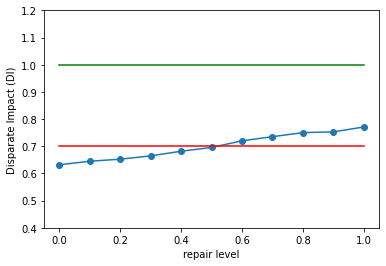

In [26]:
%matplotlib inline
plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.7, 0.7], 'r')
plt.ylim([0.4, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()

##### ii. Disparate Impact Ratio (with other Bias Mitigation Algorithms) <br>  iii. Balanced Accuracy <br> iv. Equalized Odds <br> v. Average Odds Difference <br> v. Conditional Use Accuracy Equality

We will compute these values simultaneously.

### Splitting the dataset into Train, Validation and Test sets

In [27]:
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_val, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

In [28]:
#Train classifier on original data
def train_classifier(dataset_orig_train):
    #Logistic Regression
    global scale_orig
    scale_orig = StandardScaler()
    X_train = scale_orig.fit_transform(dataset_orig_train.features)
    y_train = dataset_orig_train.labels.ravel()
    w_train = dataset_orig_train.instance_weights.ravel()
    
    lr = LogisticRegression()
    lr.fit(X_train, y_train, sample_weight=dataset_orig_train.instance_weights)
    y_train_predict = lr.predict(X_train)
    
    # positive class index
    pos_ind = np.where(lr.classes_ == dataset_orig_train.favorable_label)[0][0]
    dataset_orig_train_pred = dataset_orig_train.copy()
    dataset_orig_train_pred.labels = y_train_predict
    return lr, dataset_orig_train_pred, pos_ind

In [29]:
lr, dataset_orig_train_pred, pos_ind = train_classifier(dataset_orig_train)

In [30]:
# Obtain scores for original validation and test sets
def calculate_scores(dataset_orig_val, dataset_orig_test, classifier, pos_ind):
    dataset_orig_val_pred = dataset_orig_val.copy(deepcopy=True)
    X_val = scale_orig.transform(dataset_orig_val_pred.features)
    y_val = dataset_orig_val_pred.labels
    dataset_orig_val_pred.scores = classifier.predict_proba(X_val)[:,pos_ind].reshape(-1,1)

    dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
    X_test = scale_orig.transform(dataset_orig_test_pred.features)
    y_test = dataset_orig_test_pred.labels
    dataset_orig_test_pred.scores = classifier.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
    return (dataset_orig_val_pred, dataset_orig_test_pred), (X_val, y_val), (X_test, y_test)

In [31]:
(dataset_orig_val_pred, dataset_orig_test_pred), (X_val, y_val), (X_test, y_test) = calculate_scores(dataset_orig_val, dataset_orig_test, lr, pos_ind)

In [32]:
# Find the optimal classification threshold from the validation set
def find_optimal_clasific_thresh(dataset_orig_val, dataset_orig_val_pred):
    num_thresh = 100
    ba_arr = np.zeros(num_thresh)
    class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
    
    for idx, class_thresh in enumerate(class_thresh_arr):
        fav_inds = dataset_orig_val_pred.scores > class_thresh
        #print(fav_inds[:5], dataset_orig_val_pred.scores[:5], class_thresh)
        dataset_orig_val_pred.labels[fav_inds] = dataset_orig_val_pred.favorable_label
        dataset_orig_val_pred.labels[~fav_inds] = dataset_orig_val_pred.unfavorable_label
        #print(dataset_orig_val_pred.labels)
        
        classified_metric_orig_val = ClassificationMetric(dataset_orig_val, dataset_orig_val_pred, unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
        
        ba_arr[idx] = 0.5*(classified_metric_orig_val.true_positive_rate() + classified_metric_orig_val.true_negative_rate())
    
    best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
    best_class_thresh = class_thresh_arr[best_ind]
    print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
    print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)
    return best_class_thresh, class_thresh_arr

In [33]:
best_class_thresh, class_thresh_arr = find_optimal_clasific_thresh(dataset_orig_val, dataset_orig_val_pred)

Best balanced accuracy (no reweighing) = 0.7698
Optimal classification threshold (no reweighing) = 0.2179


In [34]:
best_class_thresh

0.21787878787878787

In [35]:
data_train_new = dataset_orig_train.copy(deepcopy=True)

### Bias Mitigation Algorithm # 3: Reject Option Class Classification

In [36]:
ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name="Statistical parity difference",
                                  metric_ub=0.05, metric_lb=-0.05)
ROC = ROC.fit(dataset_orig_val, dataset_orig_val_pred)

In [37]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.1981
Optimal ROC margin = 0.1091


In [38]:
from common_utils import compute_metrics
def compute_results(data, data_pred, clf, results, key, set_name = "validation"):
    """
    set_name-> validation or test only.
    clf-> classifier name
    """
    # Metrics for the test set
    fav_inds = data_pred.scores > best_class_thresh
    data_pred.labels[fav_inds] = data_pred.favorable_label
    data_pred.labels[~fav_inds] = data_pred.unfavorable_label
    
    display(Markdown("#### " + str(set_name) + " set"))
    display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

    metric_valid_bef = compute_metrics(data, data_pred, 
                unprivileged_groups, privileged_groups)

    results["balanced_accuracy"]["before_" + str(key)][set_name] = metric_valid_bef["Balanced accuracy"]
    results["disparate_impact_ratio"]["before_" + str(key)][set_name] = metric_valid_bef["Disparate impact"]
    results["average_odds_difference"]["before_" + str(key)][set_name] = metric_valid_bef["Average odds difference"]
    results["conditional_use_accuracy_equality"]["before_" + str(key)][set_name] = metric_valid_bef["Conditional Use Accuracy Equality"]
    results["statistical_parity_difference"]["before_" + str(key)][set_name] = metric_valid_bef["Statistical parity difference"]
    
    # Transform the validation set
    data_trans_pred = clf.predict(data_pred)
    
    display(Markdown("#### " + str(set_name) + " set"))
    display(Markdown("##### Transformed predictions - With fairness constraints"))
    metric_val_aft = compute_metrics(data, data_trans_pred, unprivileged_groups, privileged_groups)
    
    results["balanced_accuracy"]["after_" + str(key)][set_name] = metric_val_aft["Balanced accuracy"]
    results["disparate_impact_ratio"]["after_" + str(key)][set_name] = metric_val_aft["Disparate impact"]
    results["average_odds_difference"]["after_" + str(key)][set_name] = metric_val_aft["Average odds difference"]
    results["conditional_use_accuracy_equality"]["after_" + str(key)][set_name] = metric_val_aft["Conditional Use Accuracy Equality"]
    results["statistical_parity_difference"]["after_" + str(key)][set_name] = metric_val_aft["Statistical parity difference"]
    return results

In [39]:
key = "reject_option_classification"
results = compute_results(dataset_orig_test, dataset_orig_test_pred, ROC, results, key, "test")
results = compute_results(dataset_orig_val, dataset_orig_val_pred, ROC, results, key, "validation")

#### test set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.7587
Statistical parity difference = -0.3690
Disparate impact = 0.2661
Average odds difference = -0.3207
Equal opportunity difference = -0.3739
Theil index = 0.1074
Conditional Use Accuracy Equality = 0.9082


#### test set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.7324
Statistical parity difference = -0.0354
Disparate impact = 0.9081
Average odds difference = 0.0268
Equal opportunity difference = -0.0118
Theil index = 0.1212
Conditional Use Accuracy Equality = 0.8900


#### validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.7698
Statistical parity difference = -0.3751
Disparate impact = 0.2604
Average odds difference = -0.3068
Equal opportunity difference = -0.3459
Theil index = 0.1032
Conditional Use Accuracy Equality = 0.9131


#### validation set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.7409
Statistical parity difference = -0.0490
Disparate impact = 0.8757
Average odds difference = 0.0331
Equal opportunity difference = 0.0084
Theil index = 0.1176
Conditional Use Accuracy Equality = 0.8941


In [40]:
results

{'mean_difference': {'before_reweighing': -0.19911019753072282,
  'after_reweighing': 5.551115123125783e-17},
 'disparate_impact_ratio': {'before_reweighing': 0.3631666646822667,
  'after_reweighing': 1.0000000000000002,
  'before_disparate_impact_remover': 0.3631666646822667,
  'after_disparate_impact_remover': 0.7000620570902111,
  'before_reject_option_classification': {'validation': 0.2604352651643102,
   'test': 0.2660801329324019},
  'after_reject_option_classification': {'validation': 0.8756599294180772,
   'test': 0.908118054077203},
  'before_calibrated_eq_odds_postprocessing': {'validation': None,
   'test': None},
  'after_calibrated_eq_odds_postprocessing': {'validation': None,
   'test': None},
  'no_adversarial_debiasing': {'validation': None, 'test': None},
  'adversarial_debiasing': {'validation': None, 'test': None}},
 'balanced_accuracy': {'before_calibrated_eq_odds_postprocessing': {'validation': None,
   'test': None},
  'after_calibrated_eq_odds_postprocessing': {'

### Bias Mitigation Algorithm # 4: Calibrated Equilized Odds Post-processing

In [41]:
cost_constraint = "fnr" # "fnr", "fpr", "weighted"
randseed = 5
key = "calibrated_eq_odds_postprocessing"

In [42]:
key

'calibrated_eq_odds_postprocessing'

In [43]:
# Odds equalizing post-processing algorithm
# Learn parameters to equalize odds and apply to create a new dataset

ceop = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
ceop = ceop.fit(dataset_orig_val, dataset_orig_val_pred)

In [44]:
results = compute_results(dataset_orig_val, dataset_orig_val_pred, ceop, results, key, "validation")
results = compute_results(dataset_orig_test, dataset_orig_test_pred, ceop, results, key, "test")

#### validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.7698
Statistical parity difference = -0.3751
Disparate impact = 0.2604
Average odds difference = -0.3068
Equal opportunity difference = -0.3459
Theil index = 0.1032
Conditional Use Accuracy Equality = 0.9131


#### validation set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.5136
Statistical parity difference = 0.0353
Disparate impact = 164.4168
Average odds difference = 0.1109
Equal opportunity difference = 0.2097
Theil index = 0.2811
Conditional Use Accuracy Equality = 0.7535


#### test set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.7587
Statistical parity difference = -0.3690
Disparate impact = 0.2661
Average odds difference = -0.3207
Equal opportunity difference = -0.3739
Theil index = 0.1074
Conditional Use Accuracy Equality = 0.9082


#### test set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.5152
Statistical parity difference = 0.0340
Disparate impact = inf
Average odds difference = 0.1100
Equal opportunity difference = 0.2109
Theil index = 0.2759
Conditional Use Accuracy Equality = 0.7572


divide by zero encountered in double_scalars


### Bias Mitigation Algorithm # 5: Adversarial Debiasing

In [45]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

### Learn plain classifier without debiasing

In [46]:
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

In [47]:
plain_model.fit(dataset_orig_train)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 9717.597656
epoch 0; iter: 200; batch classifier loss: 1683.914307
epoch 1; iter: 0; batch classifier loss: 1020.804810
epoch 1; iter: 200; batch classifier loss: 506.089935
epoch 2; iter: 0; batch classifier loss: 371.355499
epoch 2; iter: 200; batch classifier loss: 58.479904
epoch 3; iter: 0; batch classifier loss: 21.216331
epoch 3; iter: 200; batch classifier loss: 23.025063
epoch 4; iter: 0; batch classifier loss: 6.952297
epoch 4; iter: 200; batch classifier loss: 8.819536
epoch 5; iter: 0; batch classifier loss: 33.037903
epoch 5; iter: 200; batch classifier loss: 10.148924
epoch 6; iter: 0; batch classifier loss: 12.987305
epoch 6; iter: 200; batch classifier loss: 15.437355
epoch 7; iter: 0; batch classifier loss: 19.756351
epoch 7; iter: 200; batch classifier loss: 12.284184
epoch 8; iter: 0; batch classifier loss: 4.045803
epoch 8; iter: 200; batch classifier loss: 1.600029
epoch 9; iter: 0; batch classifier loss: 2.335610
epoch 9; i

In [48]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_val = plain_model.predict(dataset_orig_val)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

##### Validation and Test data

In [49]:
#For Validation Set
metric_val_bef = compute_metrics(dataset_orig_val, dataset_nodebiasing_val, unprivileged_groups, privileged_groups)

results["balanced_accuracy"]["no_adversarial_debiasing"]["validation"] = metric_val_bef["Balanced accuracy"]
results["disparate_impact_ratio"]["no_adversarial_debiasing"]["validation"] = metric_val_bef["Disparate impact"]
results["average_odds_difference"]["no_adversarial_debiasing"]["validation"] = metric_val_bef["Average odds difference"]

#For Test Set
metric_test_bef = compute_metrics(dataset_orig_test, dataset_nodebiasing_test, unprivileged_groups, privileged_groups)

results["balanced_accuracy"]["no_adversarial_debiasing"]["test"] = metric_test_bef["Balanced accuracy"]
results["disparate_impact_ratio"]["no_adversarial_debiasing"]["test"] = metric_test_bef["Disparate impact"]
results["average_odds_difference"]["no_adversarial_debiasing"]["test"] = metric_test_bef["Average odds difference"]

Balanced accuracy = 0.6138
Statistical parity difference = -0.0480
Disparate impact = 0.5351
Average odds difference = 0.0133
Equal opportunity difference = 0.0362
Theil index = 0.2169
Conditional Use Accuracy Equality = 0.7953
Balanced accuracy = 0.6119
Statistical parity difference = -0.0593
Disparate impact = 0.4325
Average odds difference = -0.0158
Equal opportunity difference = -0.0117
Theil index = 0.2151
Conditional Use Accuracy Equality = 0.7972


In [50]:
results["disparate_impact_ratio"]["no_adversarial_debiasing"]

{'validation': 0.5350618068190373, 'test': 0.4324549822129314}

### Apply in-processing algorithm Adversarial Learning

In [51]:
sess.close()
tf.reset_default_graph()

In [52]:
from sklearn.preprocessing import MinMaxScaler

In [53]:
min_max_scaler = MinMaxScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)

In [54]:
sess = tf.Session()
# Learn parameters with debias set to True
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)

In [55]:
debiased_model.fit(dataset_orig_train)

epoch 0; iter: 0; batch classifier loss: 0.724594; batch adversarial loss: 0.622324
epoch 0; iter: 200; batch classifier loss: 0.499030; batch adversarial loss: 0.700274
epoch 1; iter: 0; batch classifier loss: 0.558683; batch adversarial loss: 0.684437
epoch 1; iter: 200; batch classifier loss: 0.564505; batch adversarial loss: 0.709375
epoch 2; iter: 0; batch classifier loss: 0.501950; batch adversarial loss: 0.689728
epoch 2; iter: 200; batch classifier loss: 0.516908; batch adversarial loss: 0.624278
epoch 3; iter: 0; batch classifier loss: 0.429721; batch adversarial loss: 0.628376
epoch 3; iter: 200; batch classifier loss: 0.409068; batch adversarial loss: 0.595432
epoch 4; iter: 0; batch classifier loss: 0.425982; batch adversarial loss: 0.680038
epoch 4; iter: 200; batch classifier loss: 0.387533; batch adversarial loss: 0.606346
epoch 5; iter: 0; batch classifier loss: 0.412521; batch adversarial loss: 0.631997
epoch 5; iter: 200; batch classifier loss: 0.385408; batch adversa

In [56]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_val = debiased_model.predict(dataset_orig_val)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

##### Validation and Test Data after implementing Adversarial Debiasing

In [57]:
#For Transformed Validation Set
metric_transf_val_bef = compute_metrics(dataset_orig_val, dataset_debiasing_val, unprivileged_groups, privileged_groups)

results["balanced_accuracy"]["adversarial_debiasing"]["validation"] = metric_transf_val_bef["Balanced accuracy"]
results["disparate_impact_ratio"]["adversarial_debiasing"]["validation"] = metric_transf_val_bef["Disparate impact"]
results["average_odds_difference"]["adversarial_debiasing"]["validation"] = metric_transf_val_bef["Average odds difference"]

#For Transformed Test Set
metric_transf_test_bef = compute_metrics(dataset_orig_test, dataset_debiasing_test, unprivileged_groups, privileged_groups)

results["balanced_accuracy"]["adversarial_debiasing"]["test"] = metric_transf_test_bef["Balanced accuracy"]
results["disparate_impact_ratio"]["adversarial_debiasing"]["test"] = metric_transf_test_bef["Disparate impact"]
results["average_odds_difference"]["adversarial_debiasing"]["test"] = metric_transf_test_bef["Average odds difference"]

Balanced accuracy = 0.5844
Statistical parity difference = -0.0323
Disparate impact = 0.5474
Average odds difference = 0.0156
Equal opportunity difference = 0.0357
Theil index = 0.2353
Conditional Use Accuracy Equality = 0.7821
Balanced accuracy = 0.6890
Statistical parity difference = -0.1068
Disparate impact = 0.4029
Average odds difference = -0.0627
Equal opportunity difference = -0.0987
Theil index = 0.1686
Conditional Use Accuracy Equality = 0.8340


In [58]:
results

{'mean_difference': {'before_reweighing': -0.19911019753072282,
  'after_reweighing': 5.551115123125783e-17},
 'disparate_impact_ratio': {'before_reweighing': 0.3631666646822667,
  'after_reweighing': 1.0000000000000002,
  'before_disparate_impact_remover': 0.3631666646822667,
  'after_disparate_impact_remover': 0.7000620570902111,
  'before_reject_option_classification': {'validation': 0.2604352651643102,
   'test': 0.2660801329324019},
  'after_reject_option_classification': {'validation': 0.8756599294180772,
   'test': 0.908118054077203},
  'before_calibrated_eq_odds_postprocessing': {'validation': 0.2604352651643102,
   'test': 0.2660801329324019},
  'after_calibrated_eq_odds_postprocessing': {'validation': 164.4168494953927,
   'test': inf},
  'no_adversarial_debiasing': {'validation': 0.5350618068190373,
   'test': 0.4324549822129314},
  'adversarial_debiasing': {'validation': 0.547441062667039,
   'test': 0.40288282495411865}},
 'balanced_accuracy': {'before_calibrated_eq_odds_p

In [59]:
results["mean_difference"]

{'before_reweighing': -0.19911019753072282,
 'after_reweighing': 5.551115123125783e-17}

In [60]:
results["statistical_parity_difference"]

{'before_reject_option_classification': {'validation': -0.3750581210385924,
  'test': -0.36900296528366605},
 'after_reject_option_classification': {'validation': -0.04897267803723804,
  'test': -0.03535585799213409},
 'before_calibrated_eq_odds_postprocessing': {'validation': -0.3750581210385924,
  'test': -0.36900296528366605},
 'after_calibrated_eq_odds_postprocessing': {'validation': 0.03532573486714066,
  'test': 0.03400447427293065}}

In [61]:
import pandas as pd

### 9. Compare your pre- and post mitigation metrics.

#### Fairness Metric 1: Mean Difference

In [62]:
mean_diff = pd.DataFrame(results["mean_difference"], index = ["Mean Difference"])
header = [["Reweighing (Pre-processing)", "Reweighing (Pre-processing)"],
          ["before", "after"]]
mean_diff.columns = header
mean_diff

Reweighing (Pre-processing)              
                                     before         after
Mean Difference                    -0.19911  5.551115e-17

As we can see that <b>Reweighing</b> (Bias Mitigation Algorithm) works well on the <b> Mean Difference</b> Fairness metric. It reduces it exponentially.

#### Fairness Metric 2: Disparate Impact Ratio

#### Comparision of Bias Mitigation Algorithms:
<ol>
    <li>Reweighing <b>(Pre-Processing)</b></li>
    <li>Disparate Impact Remover <b>(Pre-Processing)</b></li>
    <li>Reject Option Classifier <b>(Post-Processing)</b></li>
    <li>Calibrated Equalised Odds <b>(Post-Processing)</b></li>
    <li>Adversarial Debaising <b>(In-Processing)</b></li>
</ol>

In [63]:
disparate_impact_ratio = pd.DataFrame(results["disparate_impact_ratio"])
header = [["Pre-Processing", "Pre-Processing", "Pre-Processing", "Pre-Processing", "Post-Processing", "Post-Processing",
           "Post-Processing", "Post-Processing", "In-Processing", "In-Processing"], 
          ["Reweighing", "Reweighing", "Disparate Impact Remover", "Disparate Impact Remover","Reject Option Classifier",
           "Reject Option Classifier", "Calibrated Equalised Odds", "Calibrated Equalised Odds", "Adversarial Debaising", "Adversarial Debaising"],
          ["Before", "After", "Before", "After", "Before", "After", "Before", "After", "No Effect", "After Effect"]]
disparate_impact_ratio.columns = header
disparate_impact_ratio

Pre-Processing                                           \
               Reweighing       Disparate Impact Remover             
                   Before After                   Before     After   
validation       0.363167   1.0                 0.363167  0.700062   
test             0.363167   1.0                 0.363167  0.700062   

                    Post-Processing                                      \
           Reject Option Classifier           Calibrated Equalised Odds   
                             Before     After                    Before   
validation                 0.260435  0.875660                  0.260435   
test                       0.266080  0.908118                  0.266080   

                               In-Processing               
                       Adversarial Debaising               
                 After             No Effect After Effect  
validation  164.416849              0.535062     0.547441  
test               inf              0.432455     0.402883

When it comes to <b>Disparate Impact Ratio</b> Fiarness metric, <b>Reweighing</b> outperforms other algorithms to increase the disparate impact.

In [64]:
results.keys()

dict_keys(['mean_difference', 'disparate_impact_ratio', 'balanced_accuracy', 'average_odds_difference', 'statistical_parity_difference', 'conditional_use_accuracy_equality'])

In [65]:
results["balanced_accuracy"].keys()

dict_keys(['before_calibrated_eq_odds_postprocessing', 'after_calibrated_eq_odds_postprocessing', 'before_reject_option_classification', 'after_reject_option_classification', 'no_adversarial_debiasing', 'adversarial_debiasing'])

#### Fairness Metric 3: Balanced Accuracy

#### Comparision of Bias Mitigation Algorithms:
<ol>
    <li>Reject Option Classifier <b>(Post-Processing)</b></li>
    <li>Calibrated Equalised Odds <b>(Post-Processing)</b></li>
    <li>Adversarial Debaising <b>(In-Processing)</b></li>
</ol>

In [66]:
balanced_accuracy = pd.DataFrame(results["balanced_accuracy"])
header = [["Post-Processing", "Post-Processing",
           "Post-Processing", "Post-Processing", "In-Processing", "In-Processing"], 
          ["Reject Option Classifier","Reject Option Classifier", "Calibrated Equalised Odds", "Calibrated Equalised Odds",
           "Adversarial Debaising", "Adversarial Debaising"],
          ["Before", "After", "Before", "After", "No Effect", "After Effect"]]
balanced_accuracy.columns = header
balanced_accuracy

Post-Processing                                      \
           Reject Option Classifier           Calibrated Equalised Odds   
                             Before     After                    Before   
validation                 0.769790  0.513595                  0.769790   
test                       0.758687  0.515165                  0.758687   

                             In-Processing               
                     Adversarial Debaising               
               After             No Effect After Effect  
validation  0.740885              0.613788     0.584402  
test        0.732379              0.611909     0.689011

<b>Calibrated Equalised Odds</b> Algorithm performs better than other two algorithms in the <b>Balanced Accuracy</b> metric. The balanced accuracy dropped slightly from <b>77%</b> to just <b>74%</b> in validation set whereas <b>76</b> to <b>73%</b> in the test set while using <b>Calibrated Equalised Odds</b>

#### Fairness Metric 4: Average Odds Difference

#### Comparision of Bias Mitigation Algorithms:
<ol>
    <li>Reject Option Classifier <b>(Post-Processing)</b></li>
    <li>Calibrated Equalised Odds <b>(Post-Processing)</b></li>
    <li>Adversarial Debaising <b>(In-Processing)</b></li>
</ol>

In [67]:
average_odds_diff = pd.DataFrame(results["average_odds_difference"])
header = [["Post-Processing", "Post-Processing",
           "Post-Processing", "Post-Processing", "In-Processing", "In-Processing"], 
          ["Reject Option Classifier","Reject Option Classifier", "Calibrated Equalised Odds", "Calibrated Equalised Odds",
           "Adversarial Debaising", "Adversarial Debaising"],
          ["Before", "After", "Before", "After", "No Effect", "After Effect"]]
average_odds_diff.columns = header
average_odds_diff

Post-Processing                                     \
           Reject Option Classifier          Calibrated Equalised Odds   
                             Before    After                    Before   
validation                -0.306845  0.03312                 -0.306845   
test                      -0.320726  0.02675                 -0.320726   

                             In-Processing               
                     Adversarial Debaising               
               After             No Effect After Effect  
validation  0.110923              0.013310     0.015579  
test        0.110046             -0.015779    -0.062699

We got the lowest <b>Average Odds Difference (Equalised)</b> Fairness metric when using <b>Adversarial Debaising</b>/

#### Fairness Metric 5: Statistical Parity Difference

#### Comparision of Bias Mitigation Algorithms:
<ol>
    <li>Reject Option Classifier <b>(Post-Processing)</b></li>
    <li>Calibrated Equalised Odds <b>(Post-Processing)</b></li>
</ol>

#### Reject Option Classification vs Calibrated Equalised Odds Difference

In [68]:
spd = pd.DataFrame(results["statistical_parity_difference"])
header = [["Reject Option Classification", "Reject Option Classification", "Calibrated Equalised Odds Difference", "Calibrated Equalised Odds Difference"],
          ["before_using", "after_using", "before_using", "after_using"]]
spd.columns = header
spd

Reject Option Classification              \
                           before_using after_using   
validation                    -0.375058   -0.048973   
test                          -0.369003   -0.035356   

           Calibrated Equalised Odds Difference              
                                   before_using after_using  
validation                            -0.375058    0.035326  
test                                  -0.369003    0.034004

It can be seen that if we take the absolute differences <b>Calibrated Equalised Odds Difference</b> performs better than <b>Reject Option Classification</b> to reduce the bias between privilleged and unprivilleged groups.

#### Fairness Metric 5: Conditional Use Accuracy Equality

#### Comparision of Bias Mitigation Algorithms:
<ol>
    <li>Reject Option Classifier <b>(Post-Processing)</b></li>
    <li>Calibrated Equalised Odds <b>(Post-Processing)</b></li>
</ol>

#### Reject Option Classification vs Calibrated Equalised Odds Difference

In [69]:
cond_use_acc_eq = pd.DataFrame(results["conditional_use_accuracy_equality"])
header = [["Post-Processing", "Post-Processing",
           "Post-Processing", "Post-Processing"], 
          ["Reject Option Classification","Reject Option Classification", "Calibrated Equalised Odds", "Calibrated Equalised Odds"],
          ["Before", "After", "Before", "After"]]
cond_use_acc_eq.columns = header
cond_use_acc_eq

Post-Processing                                      \
           Reject Option Classification           Calibrated Equalised Odds   
                                 Before     After                    Before   
validation                     0.913105  0.894112                  0.913105   
test                           0.908173  0.889993                  0.908173   

                      
                      
               After  
validation  0.753481  
test        0.757212

In [70]:
results["conditional_use_accuracy_equality"].keys()

dict_keys(['before_reject_option_classification', 'after_reject_option_classification', 'before_calibrated_eq_odds_postprocessing', 'after_calibrated_eq_odds_postprocessing'])

We got the best accuracy when using <b>Reject Option Classificatio</b>, there is just a slight decrease in <b>Conditional Use Accuracy Equality</b>. Wehreas in <b>Calibrated Equalised Odds</b>, this accuracy decreased significantly.

### <b> Repeat steps 6 to 9 again for at least four different bias mitigation algorithms. </b> After that, you can also look into a different protected attribute.

### Fairness Tools Overview

Do a research on other fairness tools that are currently available. What are their use cases? Have some of them been used in the development of commercial products? Take a closer look on at least three other tools.

Document your findings.

#### AI Fairness Tools

##### Aequitas

<b>Aequitas</b> is an open source bias and fairness audit toolkit that was released in 2018. It is designed to enable developers to seamlessly test models for a series of bias and fairness metrics in relation to multiple population sub-groups.

##### Microsoft Fair Learn

As part of <b>Microsoft Fair Learn</b>, this is a general-purpose methodology for approaching fairness. Using binary classification, the method applies constraints to reduce fair classification to a sequence of cost-sensitive classification problems. Whose solutions yield a randomized classifier with the lowest (empirical) error subject to the desired constraints.

##### What-if Tool

The <b>What-if Tool</b> from Google is an open-source TensorBoard web application which lets users analyse an ML model without writing code. It visualises counterfactuals so that users can compare a data-point to the most similar point where the model predicts a different result. In addition, users can explore the effects of different classification thresholds, taking into account constraints such as different numerical fairness criteria.  There are a number of demos available – showing how the different functions work on pre-trained models. 

##### Deon

An ethics checklist for responsible data science, <b>Deon</b> represents a starting point for teams to evaluate considerations related to advanced analytics and machine learning applications from data collection through deployment.

##### Model Cards

As machine learning applications are becoming increasingly ubiquitous, Google Research put forward the idea of <b>Model Cards</b> to confirm that the intent of a given model matches its use case. This credential is similar to the documentation of a car’s crash test rating in different environmental conditions. Model Cards can help stakeholders to <b>understand conditions under which the model is safe and appropriate to implement.</b>

### Summary

All the Bias Mitigation Algorithms works well according to their usability. They are not supposed to satify for all metrics, their functionality is limited to their use case to solve or mitigate specific type of bias in data. In our Adult dataset, <b>Reweighing</b> performs better to reduce <b>mean_difference</b> and increase <b>disparate impact ratio</b>, while Adversarial Debaising works well to reduce <b>Average Odds Difference</b> between privilled and unprivilleged groups.